# Navigate along a corridor with one obstacle: scenario

In this scenario, one agent wants to travel along a corridor with constant speed, avoiding the single obtacle.
The obstacle is visible during the whole runs, the agent start at full speed towards the corridor and may start changing trajectory after the first control update.

The initial lateral position of agent and obstacle are picked randomly with the constraint that passing is always possible, i.e. that there is a gap of at least the agent size enlarged by its safety margin.

In [1]:
import numpy as np
from navground import core, sim
from navground_learning.scenarios.corridor_with_obstacle import CorridorWithObstacle

scenario = sim.load_scenario("""
type: CorridorWithObstacle
length: 1.0
width: 1.0
min_radius: 0.2
max_radius: 0.2
groups:
  -
    type: thymio
    number: 1
    radius: 0.08
    control_period: 0.05
    color: gold
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 10
      tau: 0.25
      eta: 0.5
      safety_margin: 0.05
      barrier_angle: 1.0
    state_estimation:
      type: Bounded
      range: 1.0
      update_static_obstacles: true
""")


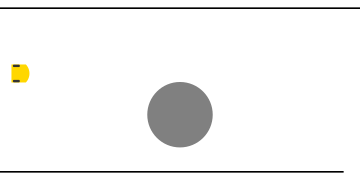

In [2]:
from navground.sim.notebook import display_in_notebook

world = sim.World()
scenario.init_world(world)

display_in_notebook(world, width=360)

In [3]:
from navground.sim.ui.video import display_video

display_video(world=world, time_step=0.1, duration=20.0, factor=5.0, display_width=360)

A typical run takes very little to compute

In [4]:
%%timeit
world = sim.World()
scenario.init_world(world)
world.run(200, 0.1)

468 µs ± 6.16 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
world.time

19.833333333333336

The task is simple but not trivial, even for the rule-based behavior like HL. In fact, sometimes, the gap on one side is almost good for the agent to pass safely, but not quite: it is possible that the agent is too near and does not manage to change side in time. In our scenario, `HL` is setup to that it will try to pass anyway (`barrier_angle` $<\pi/2$)  incurring in a violation of the safety margin. This event is relatively rare, and for the majority of runs, the agent passes safely. 

Let us plot few trajectories when using `HL`

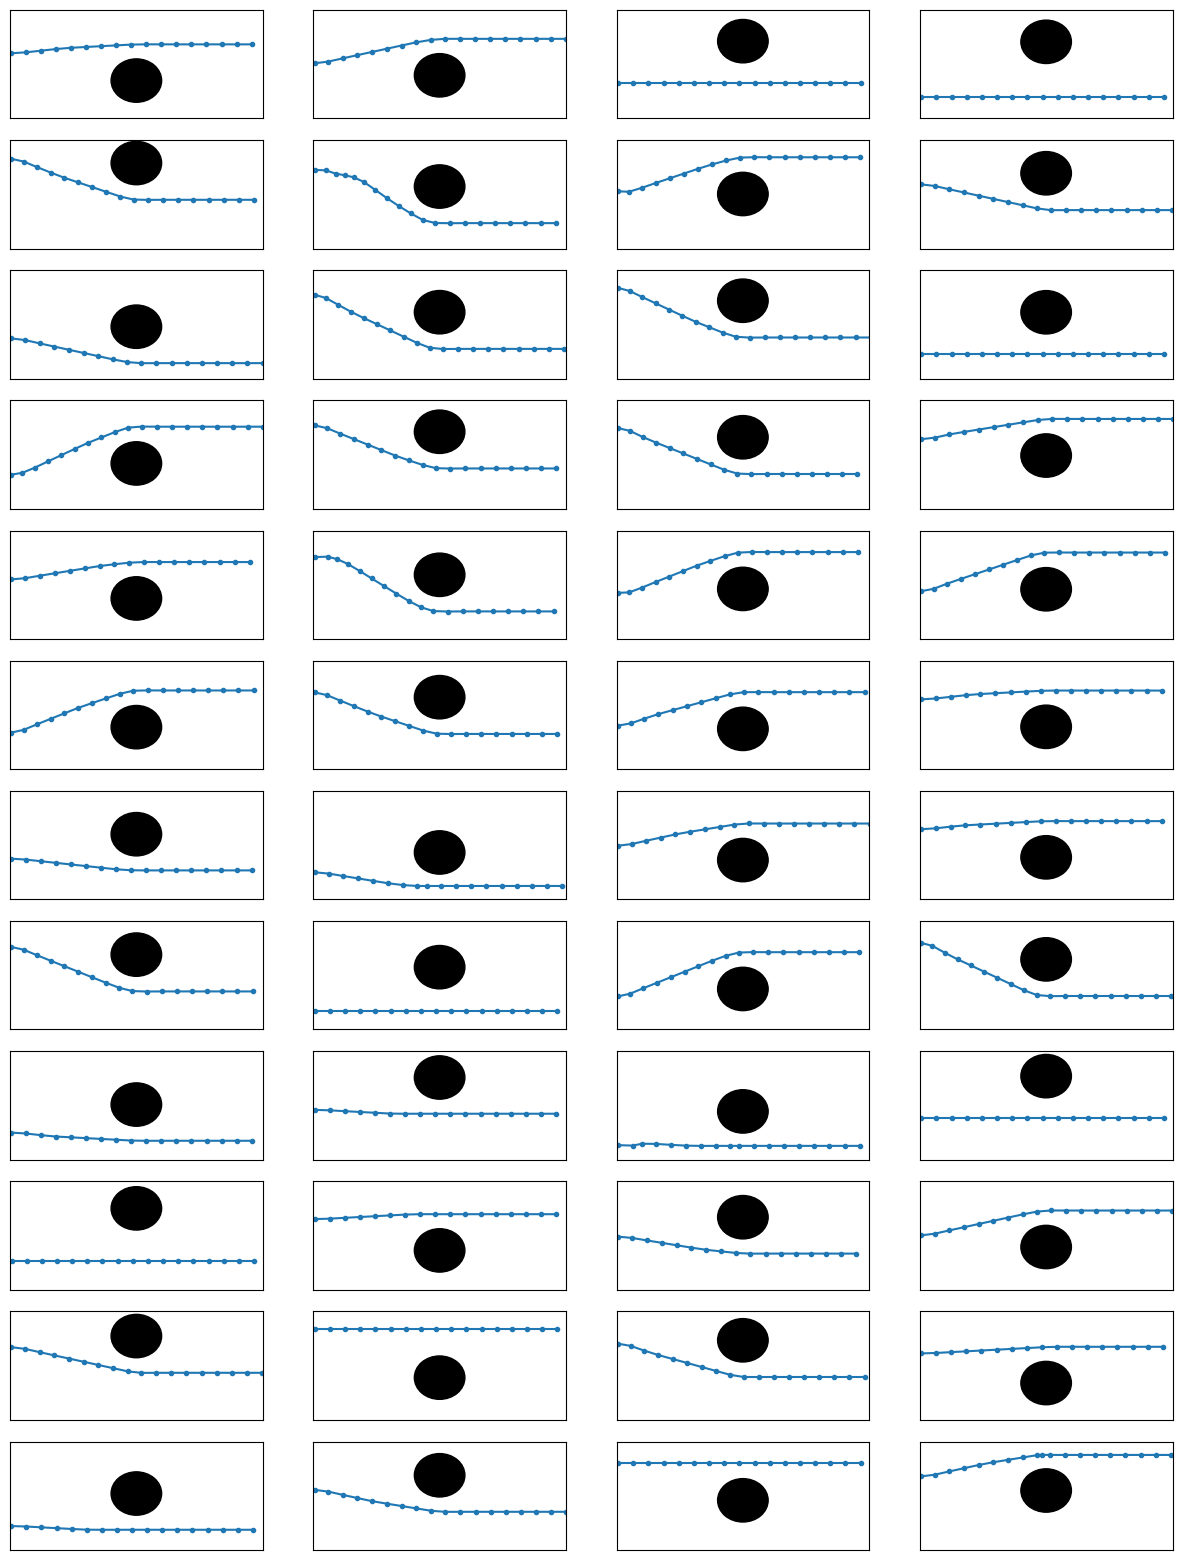

In [6]:
from matplotlib import pyplot as plt

exp = sim.Experiment(time_step=0.1, steps=300)
exp.scenario = scenario
exp.record_config.pose = True
exp.run(number_of_runs=48)

_, axs = plt.subplots(12, 4, figsize=(15, 20))
for ax, run in zip(axs.flatten(), exp.runs.values()):
    o = run.world.obstacles[0].disc
    c = plt.Circle(o.position, o.radius, color='k')
    ax.add_patch(c)
    ps = run.poses[..., :2].reshape(-1, 2)
    ax.plot(*ps[::10].T, '.-')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 2)
    ax.tick_params(left=False, bottom=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

We want to learn doing the same task using a sensor

In [7]:
sensor = sim.load_state_estimation("""
type: Combination
sensors:
  - type: Boundary
    min_y: 0
    max_y: 1
    range: 1
  - type: Discs
    number: 1
    range: 1
    max_speed: 0.0
    max_radius: 0.0
    include_valid: false
""")

that perceives

- the nearest point of the obstacle
- the distance to the left and right walls

The agent input will be 

- the sensing reading (see above)
- the own speed in body frame
- the own angular speed
- the own targer direction in body frame

and should output an acceleration command (linear and angular).

We measure the quality of the trajectoty by a reward that penalizes

- safety margin violations (violating by at most 1 cm is excused)
- not moving at full speed along the corridor

A trajectory cannot have more than 0 reward, which can happen only if the obstacle is not in the way.

In [8]:
import gymnasium as gym
from navground_learning.utils import GymAgentConfig
from navground_learning.env import social_reward

duration = 40.0
time_step = 0.1

config = GymAgentConfig(include_target_distance=False, include_velocity=True,
                        include_angular_speed=True, max_acceleration=1.0, 
                        max_angular_acceleration=10.0, use_acceleration_action=True,
                        flat=False)

env = gym.make('navground', 
    scenario=scenario,
    sensor=sensor,
    config=config,
    time_step=time_step,
    max_duration=duration,
    reward=social_reward(safety_margin=0.04))

Let us look at the rewards using `HL`

In [16]:
def get_expert_reward(env, seed=None):
    obs, info = env.reset(seed=seed)
    done = False
    cum_rew = 0
    while not done:
        obs, rew, te, tr, info = env.step(info['navground_action'])
        done = te or tr
        cum_rew += rew              
    return cum_rew

In [17]:
rewards = np.asarray([get_expert_reward(env, seed=i) for i in range(1000)])

In [18]:
np.min(rewards),  np.mean(rewards), np.median(rewards), np.max(rewards)

(-65.28052899347895, -5.433805959060551, -3.9665543284519917, 0.0)

and the run with lowest rewards

In [19]:
seed = int(np.argmin(rewards))
seed, rewards[seed]

(158, -65.28052899347895)

In [20]:
world = sim.World()
scenario.init_world(world, seed=seed)
display_video(world=world, time_step=0.1, duration=20.0, factor=5.0, display_width=360)

which is one of the cases we discussed at the beginning, where the agent is passing on the "wrong" side of the obstacle.

In about 20% of the runs, the agent just goes straight

In [21]:
p_straight = sum(rewards == 0) / len(rewards)
p_straight

0.222

and in all the other runs it has to actually avoid the obstacles, incurring in a penality 

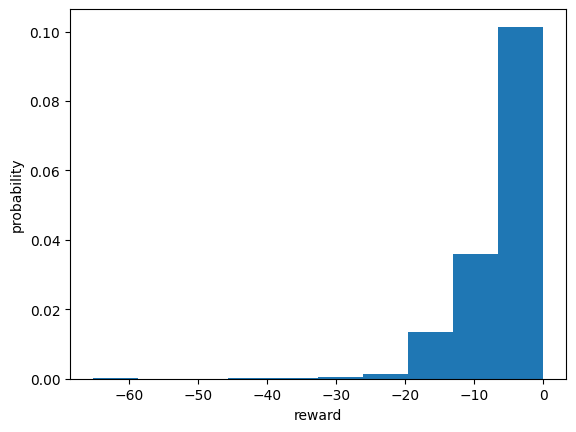

In [22]:
plt.hist(rewards, bins=10, density=True);
plt.xlabel('reward')
plt.ylabel('probability');

Finally, we have a look at the input/output distributions

In [23]:
from imitation.util.util import make_vec_env
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from navground_learning.utils import Expert

expert = Expert(config)

rng = np.random.default_rng(0)
venv = make_vec_env("navground",
    rng=rng,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
    env_make_kwargs={
        'scenario': scenario,
        'sensor': sensor,
        'time_step': 0.1,
        'max_duration': 20,
        'config': config,
    },
    parallel=False,
    n_envs=1)

rollouts = rollout.rollout(
    expert, venv, 
    rollout.make_sample_until(min_timesteps=None, min_episodes=1000), 
    exclude_infos = False,
    rng=rng)
transitions = rollout.flatten_trajectories(rollouts)

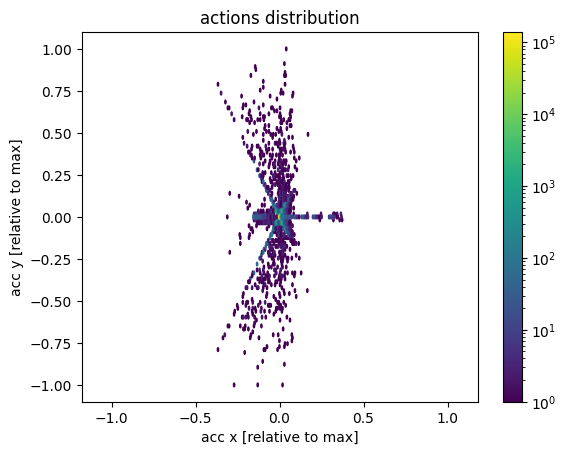

In [24]:
from matplotlib import pyplot as plt

plt.hexbin(*transitions.acts.T, bins='log');
plt.axis('equal')
plt.xlabel('acc x [relative to max]')
plt.ylabel('acc y [relative to max]')
plt.colorbar()
plt.title('actions distribution');

In [25]:
transitions.obs.keys()

dict_keys(['boundary_distance', 'position', 'ego_velocity', 'ego_angular_speed', 'ego_target_direction'])

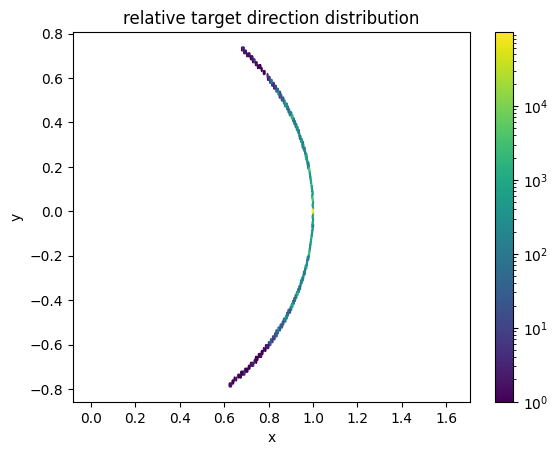

In [26]:
plt.hexbin(*transitions.obs.get('ego_target_direction').T, bins='log');
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('relative target direction distribution');

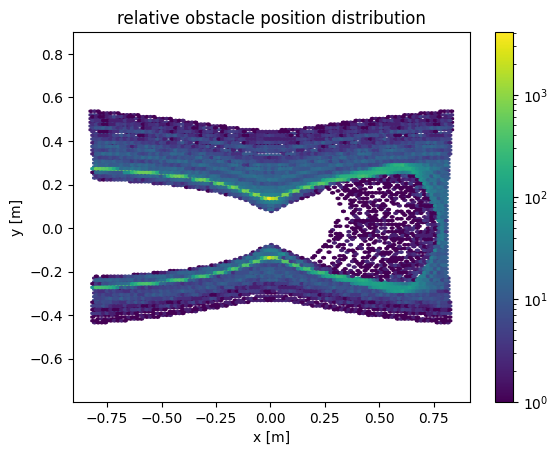

In [27]:
plt.hexbin(*transitions.obs.get('position').T, bins='log');
plt.axis('equal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.title('relative obstacle position distribution');

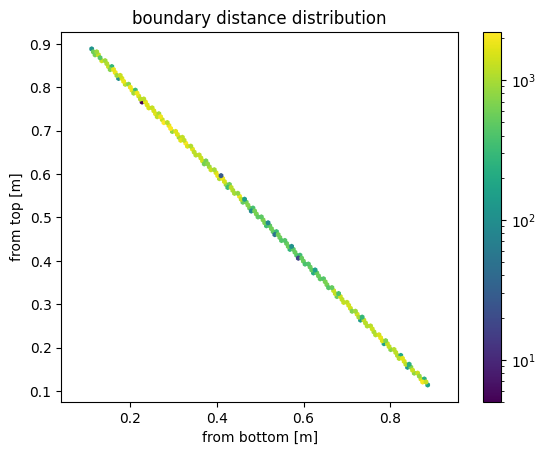

In [28]:
plt.hexbin(*transitions.obs.get('boundary_distance').T, bins='log');
plt.xlabel('from bottom [m]')
plt.ylabel('from top [m]')
plt.axis('equal')
plt.colorbar()
plt.title('boundary distance distribution');

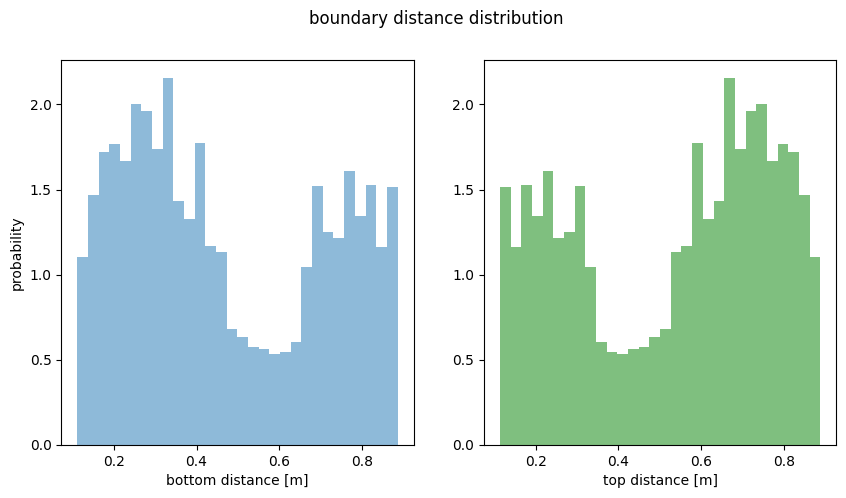

In [29]:
bottom, top = transitions.obs.get('boundary_distance').T
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('boundary distance distribution');
axs[0].hist(bottom, bins=30, density=True, label="bottom", alpha=0.5);
axs[1].hist(top, bins=30, density=True, label="top", alpha=0.5, color='g');
axs[0].set_xlabel('bottom distance [m]')
axs[1].set_xlabel('top distance [m]')
axs[0].set_ylabel('probability');

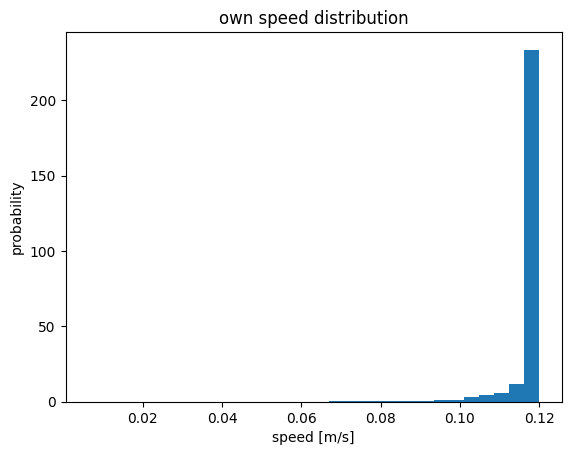

In [32]:
plt.hist(transitions.obs.get('ego_velocity').flatten(), bins=30, density=True);
plt.xlabel('speed [m/s]')
plt.ylabel('probability')
plt.title('own speed distribution');

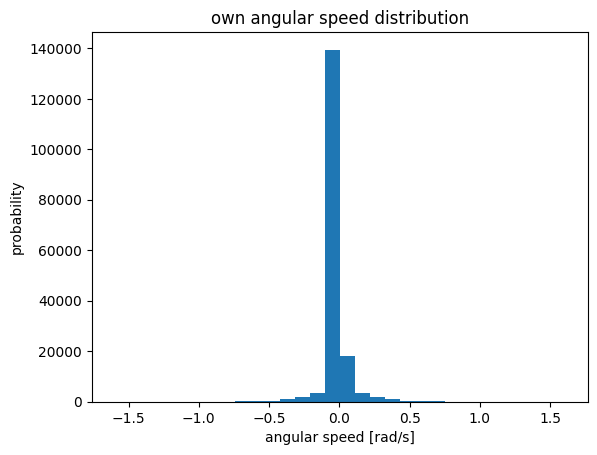

In [33]:
plt.hist(transitions.obs.get('ego_angular_speed').flatten(), bins=30);
plt.xlabel('angular speed [rad/s]')
plt.ylabel('probability')
plt.title('own angular speed distribution');